### Name: 
**Sajith Gowthaman**
### Project Name:
Final Capstone - Predicting Covid-19 using Regression model and Convolutional Neural Networks.

### Description:
Covid-19: A novel coronavirus is a new strain of coronavirus that has not been previously identified in humans.
Coronaviruses (CoV) are a large family of viruses transmitting between animals and people that cause illness ranging from the common cold to more severe diseases such as Middle East respiratory syndrome (MERS-CoV) and severe acute respiratory syndrome (SARS-CoV).

As the virus is wild spread, it is the duty of data scientists and enthusiasts to provide the health care industry with useful insights.

<img src="https://user-images.githubusercontent.com/55968160/80459872-e3ddac80-88e7-11ea-952c-7d4909a01d42.png" width = "400" height ="600" />

The project is split into two parts:
1) Predicting the positive cases using Regression Model
2) Predicting the chest x-ray image using Convolutional Neural Network

The [data]('https://covidtracking.com/') for predicting the positive cases is taken from the "The Covid-19 Tracking Project". The data is uploaded on a daily basis. This part of the project will include useful insights, grouped statewise to find solutions through record of improvement. 

The data for predicting the chest x-rays are taking from an open base research dataset on a [github repository]('https://github.com/ieee8023/covid-chestxray-dataset') where I was able to access 340+ (Augmented to about 3k+ images) Covid-19 chest xray images. I took a bunch of normal x-rays found on Kaggle to do this analysis.

### How is this project different and who will it help?
A lot of people have been using their time off to visualize the covid-19 which is really useful. 
This project will combine the unique idea of both predicting the positive cases and predicting the presence of the virus through just inserting the chest x-ray. This will ease the work load on health care workers to assume the present of covid-19 without waiting 3 days for the test results. The patient could be treated as a victim of covid-19 if the deep learning model predicts positive, atleast till the clinical results come out.

In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn import preprocessing
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder
import plotly.figure_factory as ff
import pandas as pd
import seaborn as sns
import warnings

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

os.chdir("..")


warnings.filterwarnings('ignore')
matplotlib.style.use("fivethirtyeight")

In [2]:
df = pd.read_csv("https://covidtracking.com/api/states/daily.csv")

In [3]:
df.head()

date state  positive  negative  pending  hospitalizedCurrently  \
0  20200501    AK     364.0   19961.0      NaN                   25.0   
1  20200501    AL    7158.0   84775.0      NaN                    NaN   
2  20200501    AR    3321.0   46355.0      NaN                   95.0   
3  20200501    AS       0.0      57.0      NaN                    NaN   
4  20200501    AZ    7962.0   66917.0      NaN                  709.0   

   hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
0                     NaN             NaN              NaN   
1                  1008.0             NaN            335.0   
2                   414.0             NaN              NaN   
3                     NaN             NaN              NaN   
4                  1203.0           311.0              NaN   

   onVentilatorCurrently  ...  hospitalized    total totalTestResults  \
0                    NaN  ...           NaN  20325.0          20325.0   
1                    NaN  ...        1008.0  91933.0          91933.0   
2                   23.0  ...         414.0  49676.0          49676.0   
3                    NaN  ...           NaN     57.0             57.0   
4                  187.0  ...        1203.0  74879.0          74879.0   

    posNeg  fips  deathIncrease  hospitalizedIncrease  negativeIncrease  \
0  20325.0     2            0.0                   0.0            1197.0   
1  91933.0     1           10.0                  30.0            4598.0   
2  49676.0     5            3.0                  12.0            1231.0   
3     57.0    60            0.0                   0.0              54.0   
4  74879.0     4           10.0                  34.0            2779.0   

   positiveIncrease  totalTestResultsIncrease  
0               9.0                    1206.0  
1             139.0                    4737.0  
2              66.0                    1297.0  
3               0.0                      54.0  
4             314.0                    3093.0  

[5 rows x 25 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3209 entries, 0 to 3208
Data columns (total 25 columns):
date                        3209 non-null int64
state                       3209 non-null object
positive                    3194 non-null float64
negative                    3028 non-null float64
pending                     666 non-null float64
hospitalizedCurrently       1113 non-null float64
hospitalizedCumulative      1175 non-null float64
inIcuCurrently              552 non-null float64
inIcuCumulative             216 non-null float64
onVentilatorCurrently       437 non-null float64
onVentilatorCumulative      66 non-null float64
recovered                   958 non-null float64
hash                        3209 non-null object
dateChecked                 3209 non-null object
death                       2482 non-null float64
hospitalized                1175 non-null float64
total                       3207 non-null float64
totalTestResults            3207 non-null float64
posNe

Visualization

In [5]:
top_10 = df.sort_values('total',ascending = False).drop_duplicates(['state'])
top_10.state.head(10)

37    NY
5     CA
10    FL
47    TX
21    MA
16    IL
34    NJ
41    PA
52    WA
24    MI
Name: state, dtype: object

For visualization, we will use the top 10 states with the highest number of cases. 
* The states with the highest number of cases are NY, CA, FL, TX, MA, NJ, IL, PA, MI, WA

In [6]:
vis_df = df.loc[df['state'].isin(['NY','CA', 'FL', 'TX', 'MA', 'NJ', 'IL', 'PA', 'MI', 'WA'])]
## Reset Index
vis_df = vis_df.reset_index(drop=True)
vis_df.head()

date state  positive  negative  pending  hospitalizedCurrently  \
0  20200501    CA   50442.0  604543.0      NaN                 4706.0   
1  20200501    FL   34728.0  367971.0      NaN                    NaN   
2  20200501    IL   56055.0  228633.0      NaN                 4900.0   
3  20200501    MA   64311.0  225325.0      NaN                 3716.0   
4  20200501    MI   42356.0  148149.0      NaN                 2319.0   

   hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
0                     NaN          1434.0              NaN   
1                  5795.0             NaN              NaN   
2                     NaN          1263.0              NaN   
3                  6169.0           947.0              NaN   
4                     NaN           966.0              NaN   

   onVentilatorCurrently  ...  hospitalized     total totalTestResults  \
0                    NaN  ...           NaN  654985.0         654985.0   
1                    NaN  ...        5795.0  402699.0         402699.0   
2                  777.0  ...           NaN  284688.0         284688.0   
3                    NaN  ...        6169.0  289636.0         289636.0   
4                  760.0  ...           NaN  190505.0         190505.0   

     posNeg  fips  deathIncrease  hospitalizedIncrease  negativeIncrease  \
0  654985.0     6           91.0                   0.0           28123.0   
1  402699.0    12           24.0                   0.0           19256.0   
2  284688.0    17          102.0                   0.0           11684.0   
3  289636.0    25          154.0                 227.0           11883.0   
4  190505.0    26           77.0                   0.0            9261.0   

   positiveIncrease  totalTestResultsIncrease  
0            1525.0                   29648.0  
1            1038.0                   20294.0  
2            3137.0                   14821.0  
3            2106.0                   13989.0  
4             977.0                   10238.0  

[5 rows x 25 columns]

In [7]:
vis_df.columns

Index(['date', 'state', 'positive', 'negative', 'pending',
       'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently',
       'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative',
       'recovered', 'hash', 'dateChecked', 'death', 'hospitalized', 'total',
       'totalTestResults', 'posNeg', 'fips', 'deathIncrease',
       'hospitalizedIncrease', 'negativeIncrease', 'positiveIncrease',
       'totalTestResultsIncrease'],
      dtype='object')

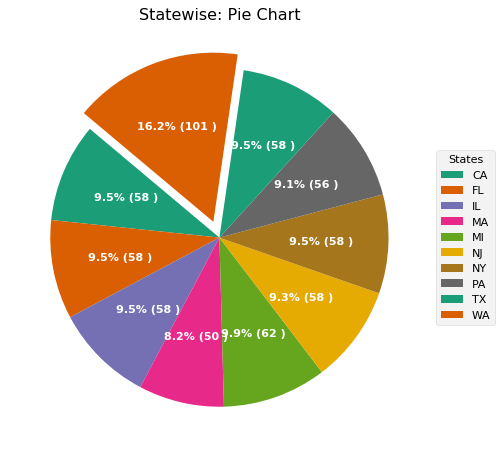

In [8]:
df_select = vis_df
# Prepare Data
df_select = df_select.groupby('state').size().reset_index(name='total')

# Draw Plot
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw=dict(aspect="equal"), dpi= 80)

data = df_select['total']
categories = df_select['state']
explode = [0,0,0,0,0,0,0,0,0,0.1]
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=plt.cm.Dark2.colors,
                                 startangle=140,
                                 explode=explode)

# Decoration
ax.legend(wedges, categories, title="States", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Statewise: Pie Chart")
plt.show()

Not to mislead you, this is a subset of the data, so the rates will differ. The statewise highest number of rates is still New York with 308,000 cases at the moment (May 1st)

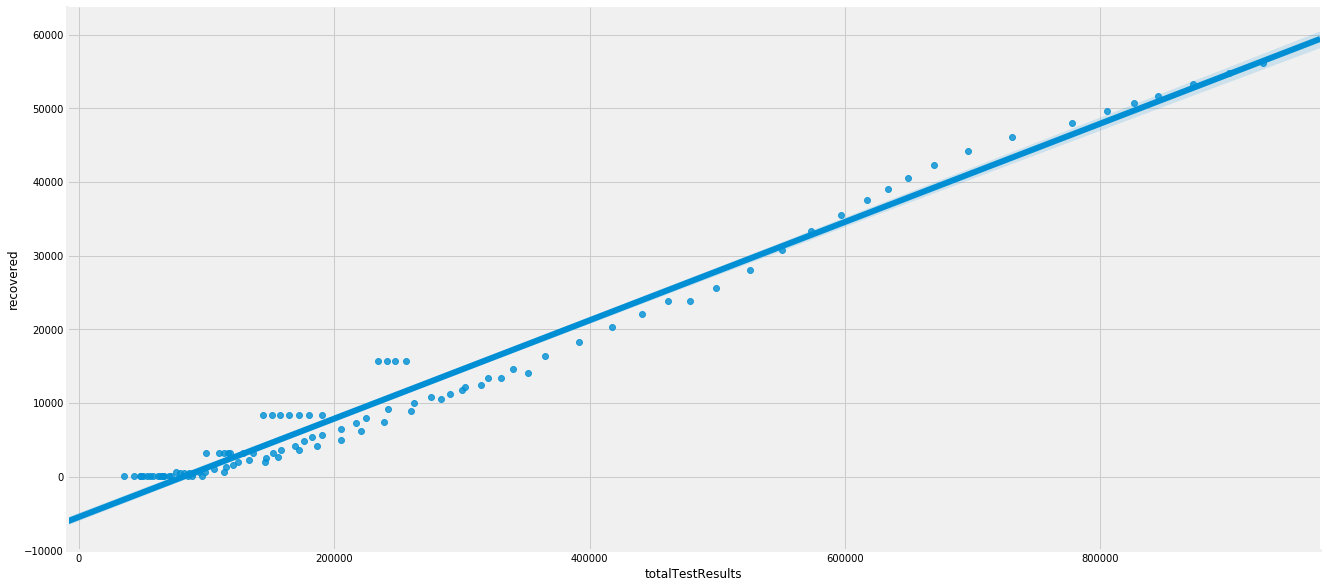

In [9]:
plt.figure(figsize=(20,10))
sns.regplot(
    x='totalTestResults',
    y='recovered',
    data=vis_df,    
)
sns.despine() # prettier layout

As the test increases, the recovery increases. This could mean that those who were tested positive are quarantined reducing the risks of spreading it further. With increase in tests, the number of cases will eventually increase, but the rate of death will comparatively be lesser. We could check which state has recovered the most and follow their way of lifestyle to flatten the curve. 


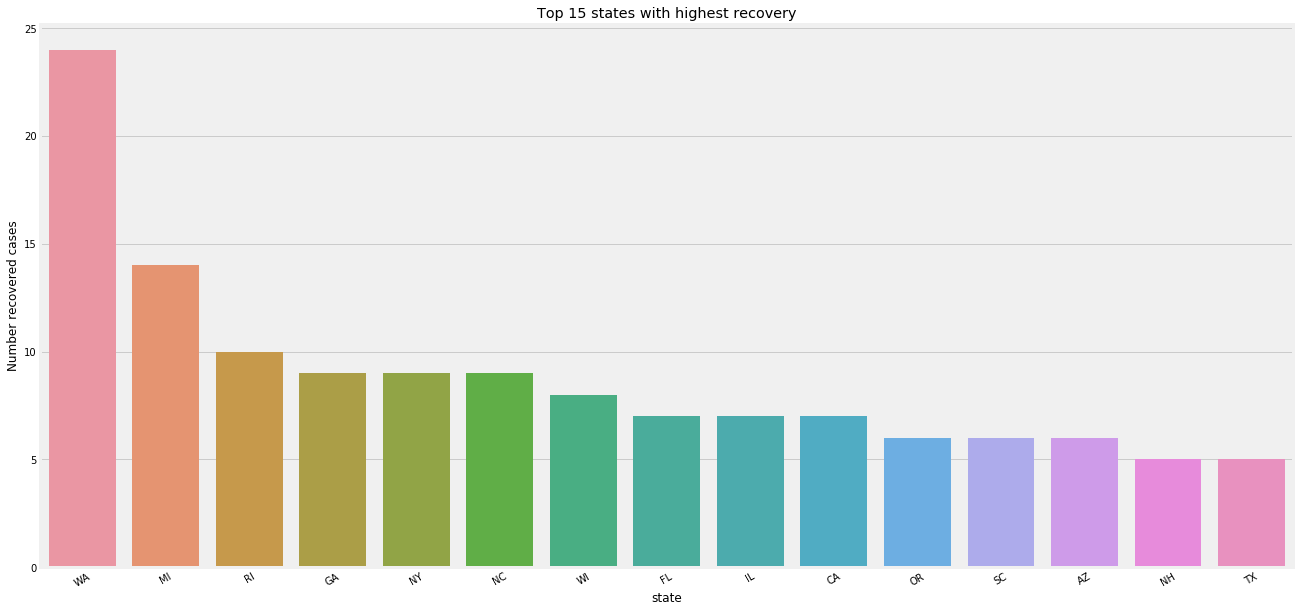

In [10]:
plt.figure(figsize=(20,10))

sns.barplot(x=df['state'].value_counts().nlargest(15).index, 
            y=df['recovered'].value_counts().nlargest(15))

plt.xticks(rotation=30)
plt.title('Top 15 states with highest recovery')
plt.xlabel('state')
plt.ylabel('Number recovered cases')
plt.show()

We see a high recovery in WA. Today (27th April 2020), there are 508 patients hospitalized with COVID-19, and 145 of them are in intensive care in WA. according to KOMONEWS. This could be the reason the governor has announced gradual opening of economy. 

In [11]:
# vis_df data is prone to misreported numbers or errors, we can smooth the reported positives by looking at 
# positive case growth every 2 days. credits: from the git hub repo. 
vis_df["positiveIncreaseLag"] = vis_df.groupby("state")["positiveIncrease"].shift(1)
vis_df["twoDayPositiveIncrease"] = vis_df["positiveIncrease"] + vis_df["positiveIncreaseLag"]
smoothed_vis_df = vis_df.loc[vis_df["date"] % 2 == 0]

# plot drop off
smoothed_vis_df["logPositiveNew"] = np.log(smoothed_vis_df["twoDayPositiveIncrease"])
smoothed_vis_df["logPositiveTotal"] = np.log(smoothed_vis_df["positive"])


# plot variables and settings
latest_update = str(smoothed_vis_df["date"].max())

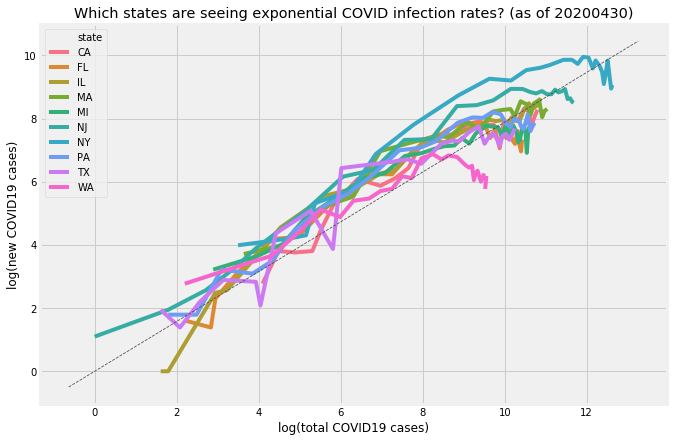

In [12]:
plt.figure(figsize=(10,7))
ax = sns.lineplot(
    x="logPositiveTotal",
    y="logPositiveNew",
    hue="state",
    data=smoothed_vis_df
)

ax.set(
    xlabel="log(total COVID19 cases)",
    ylabel="log(new COVID19 cases)",
    title=f"Which states are seeing exponential COVID infection rates? (as of {latest_update})"
)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3", lw=.8)
plt.show()

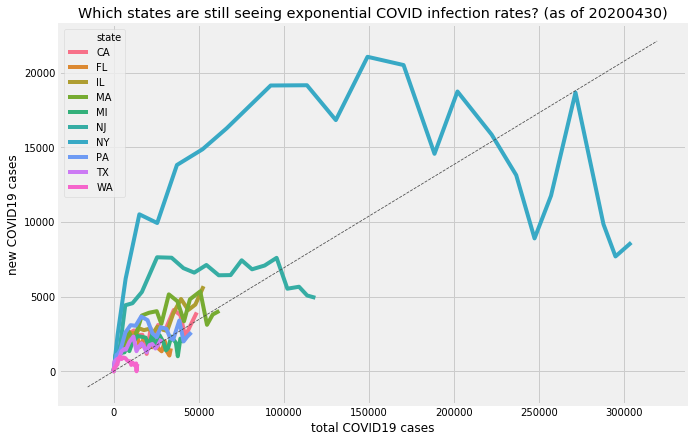

In [13]:
# linear-scale plot of growth rate v total (positives)
plt.figure(figsize=(10,7))
ax = sns.lineplot(
    x="positive",
    y="twoDayPositiveIncrease",
    hue="state",
    data=smoothed_vis_df
)

ax.set(
    xlabel="total COVID19 cases",
    ylabel="new COVID19 cases",
    title=f"Which states are still seeing exponential COVID infection rates? (as of {latest_update})"
)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3", lw=.8)
plt.show()


We can see that the new covid cases for New York and New Jersey have crossed the peak point and are starting to decline slowly. However, the plot might seem a lot volatile at the moment as it has just started to decline and will take atleast a week to form a steady downfall.

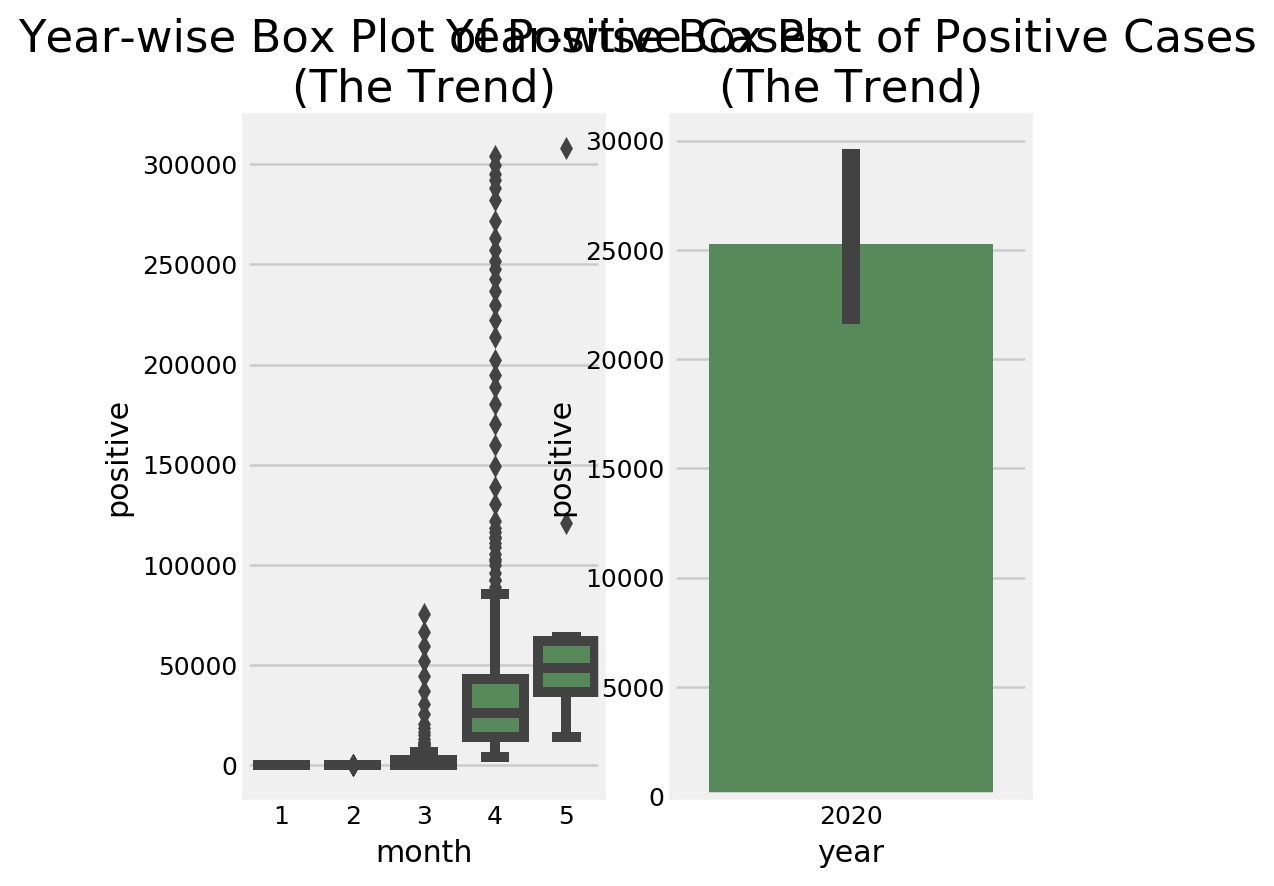

In [14]:
#drawing boxplot
fig, axes = plt.subplots(1, 2, figsize = (5,5), dpi = 180)
vis_df1= vis_df

vis_df1.date = pd.to_datetime(vis_df1['date'], format='%Y%m%d')
vis_df1['month'] = pd.DatetimeIndex(vis_df1['date']).month
vis_df1['year'] = pd.DatetimeIndex(vis_df1['date']).year

mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), replace = False)
sns.barplot(x = 'year', y = 'positive', data = vis_df1, ax = axes[1], color = mycolors)
sns.boxplot(x = 'month', y = 'positive', data = vis_df1, ax = axes[0], color = mycolors)

# Set Title
axes[0].set_title('Year-wise Box Plot of Positive Cases\n(The Trend)', fontsize = 18);
axes[1].set_title('Year-wise Box Plot of Positive Cases\n(The Trend)', fontsize = 18); 
plt.show()

We can clearly see the inflation in the boxplot from March to April and then May. However, they are claiming that the curve is flattening. Could be true as the number of tests increases, cases will proportionally increase too. What matters is the fatality rate and USA has done a great job in keeping it under most countries like Spain, UK etc. kudos to the health care workers and first responders!

For all you know, this pandemic could persist till next year or maybe even more. So, I have added an extra plot just the behavior of the plots can differ down the years.

Data Modeling

In [15]:
df.isnull().sum()

date                           0
state                          0
positive                      15
negative                     181
pending                     2543
hospitalizedCurrently       2096
hospitalizedCumulative      2034
inIcuCurrently              2657
inIcuCumulative             2993
onVentilatorCurrently       2772
onVentilatorCumulative      3143
recovered                   2251
hash                           0
dateChecked                    0
death                        727
hospitalized                2034
total                          2
totalTestResults               2
posNeg                         2
fips                           0
deathIncrease                 56
hospitalizedIncrease          56
negativeIncrease              56
positiveIncrease              56
totalTestResultsIncrease      56
dtype: int64

Lets drop columns that has a high number of null values

In [16]:
df.drop(columns=['pending','hospitalizedCurrently','hospitalizedCumulative', 'hospitalized', 'inIcuCurrently', 'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative','recovered','hash','dateChecked', 'date'], inplace = True)
df.isnull().sum()

state                         0
positive                     15
negative                    181
death                       727
total                         2
totalTestResults              2
posNeg                        2
fips                          0
deathIncrease                56
hospitalizedIncrease         56
negativeIncrease             56
positiveIncrease             56
totalTestResultsIncrease     56
dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3209 entries, 0 to 3208
Data columns (total 13 columns):
state                       3209 non-null object
positive                    3194 non-null float64
negative                    3028 non-null float64
death                       2482 non-null float64
total                       3207 non-null float64
totalTestResults            3207 non-null float64
posNeg                      3207 non-null float64
fips                        3209 non-null int64
deathIncrease               3153 non-null float64
hospitalizedIncrease        3153 non-null float64
negativeIncrease            3153 non-null float64
positiveIncrease            3153 non-null float64
totalTestResultsIncrease    3153 non-null float64
dtypes: float64(11), int64(1), object(1)
memory usage: 326.0+ KB


In [18]:
LE = LabelEncoder()
df.state = LE.fit_transform(df.state)

In [19]:
df.describe()

state       positive       negative         death          total  \
count  3209.000000    3194.000000    3028.000000   2482.000000    3207.000000   
mean     27.886569    6763.801816   32000.713342    389.767526   37252.552229   
std      16.284494   24105.189949   62518.489215   1503.105156   81019.321543   
min       0.000000       0.000000       0.000000      0.000000       0.000000   
25%      14.000000      47.000000     642.000000      5.000000     449.000000   
50%      28.000000     675.500000   10162.500000     37.000000    9453.000000   
75%      42.000000    3907.250000   36414.000000    189.000000   39109.500000   
max      55.000000  308314.000000  619124.000000  18610.000000  927438.000000   

       totalTestResults         posNeg         fips  deathIncrease  \
count       3207.000000    3207.000000  3209.000000    3153.000000   
mean       36950.964453   36950.964453    32.254596      18.731050   
std        80846.011946   80846.011946    18.488918      67.132313   
min            0.000000       0.000000     1.000000    -201.000000   
25%          406.500000     406.500000    17.000000       0.000000   
50%         9355.000000    9355.000000    32.000000       1.000000   
75%        38760.000000   38760.000000    46.000000       9.000000   
max       927438.000000  927438.000000    78.000000     799.000000   

       hospitalizedIncrease  negativeIncrease  positiveIncrease  \
count           3153.000000       3153.000000       3153.000000   
mean              39.496036       1730.128766        347.468126   
std              248.236086       4435.016083        980.628287   
min             -655.000000      -5086.000000       -383.000000   
25%                0.000000         17.000000          5.000000   
50%                0.000000        469.000000         57.000000   
75%                5.000000       1923.000000        257.000000   
max             7758.000000     163092.000000      11571.000000   

       totalTestResultsIncrease  
count               3153.000000  
mean                2077.596892  
std                 4969.261595  
min                -4714.000000  
25%                   42.000000  
50%                  561.000000  
75%                 2236.000000  
max               165227.000000

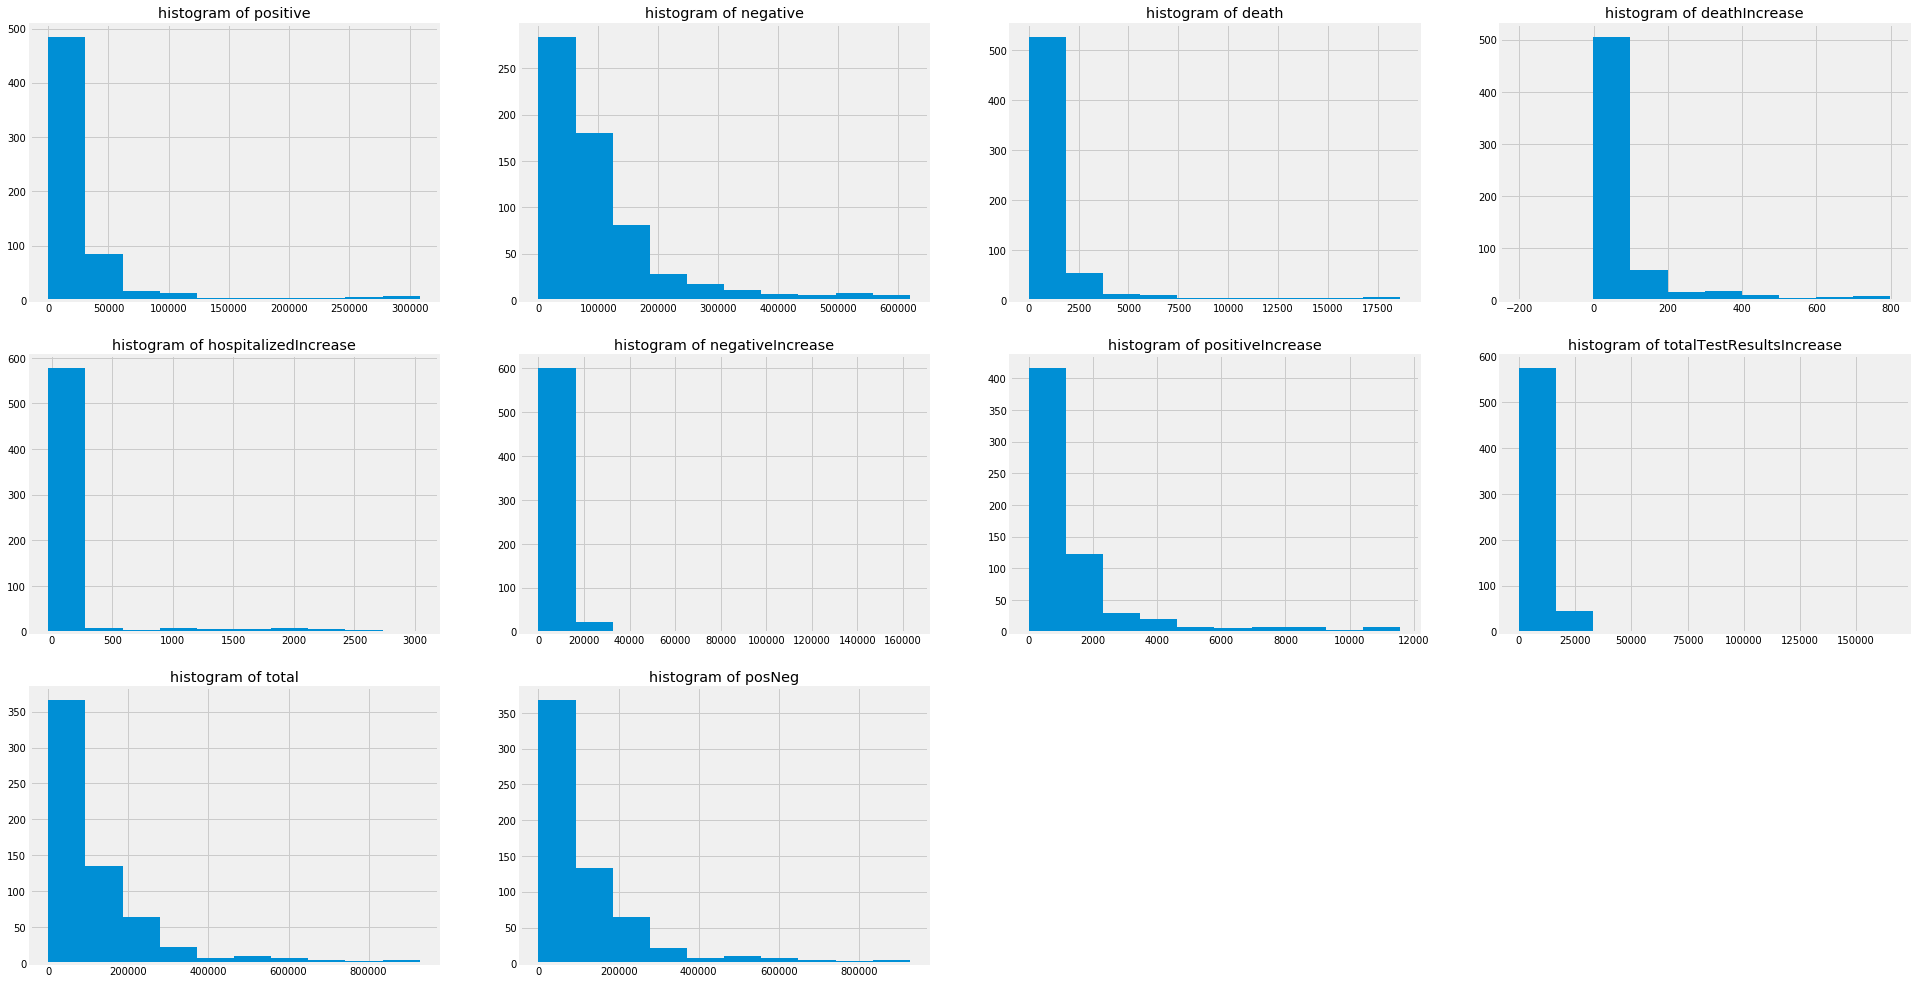

In [20]:
#Let's check the distribution:
List = ['positive', 'negative', 'death','deathIncrease', 'hospitalizedIncrease','negativeIncrease', 'positiveIncrease', 'totalTestResultsIncrease','total','posNeg']
plt.figure(figsize=(30,60))
for i, col in enumerate (List):
    vis_df[col].fillna(vis_df[col].mean(), inplace=True)
    plt.subplot(len(List),4,i+1)
    plt.hist((vis_df[col]))
    plt.title("histogram of {}".format(col))

plt.show()

The data is highly skewed, which is expected from this kind of dataset. 
Three ways to deal with skewed data: 
* log transformation
* Scipy's boxcox transformation
* Mean square root
* winsorizing the data to remove outliers

**We will use log transformation and winsorization to get a better distribution.**

In [21]:
#Our data is highly skewed, the first step is to try np.log
#let's do that for observations greater than 0 as log would yield an infinite value for 0.
df.positive = np.log(df['positive'], where=df.positive>0)
df.negative = np.log(df['negative'], where=df.negative>0)
df.hospitalizedIncrease = np.log(df['hospitalizedIncrease'], where=df.hospitalizedIncrease>0)
df.death = np.log(df['death'], where=df.death>0)
df.negativeIncrease = np.log(df['negativeIncrease'], where=df.negativeIncrease>0)
df.positiveIncrease = np.log(df['positiveIncrease'], where=df.positiveIncrease>0)
df.totalTestResultsIncrease = np.log(df['totalTestResultsIncrease'], where=df.totalTestResultsIncrease>0)
df.total = np.log(df['total'], where=df.total>0)
df.totalTestResults = np.log(df['totalTestResults'], where=df.totalTestResults>0)
df.posNeg = np.log(df['posNeg'], where=df.posNeg>0)
df.deathIncrease = np.log(df['deathIncrease'], where=df.deathIncrease>0)

In [22]:
List = ['positive', 'negative','hospitalizedIncrease', 'death','negativeIncrease', 'positiveIncrease', 'totalTestResultsIncrease', 'total','totalTestResults','posNeg','deathIncrease']
for i, col in enumerate (List):
#Normalizing the variable to get a better distribution
    df[col].fillna(df[col].mean(), inplace =True)
    df[col] = winsorize(df[col], (0.18, 0.18))
#HospitalizedIncrease requires more winsorizing as the outliers dont seem to decrease with the previous level.
df.hospitalizedIncrease = winsorize(df.hospitalizedIncrease,(0.10,0.21))

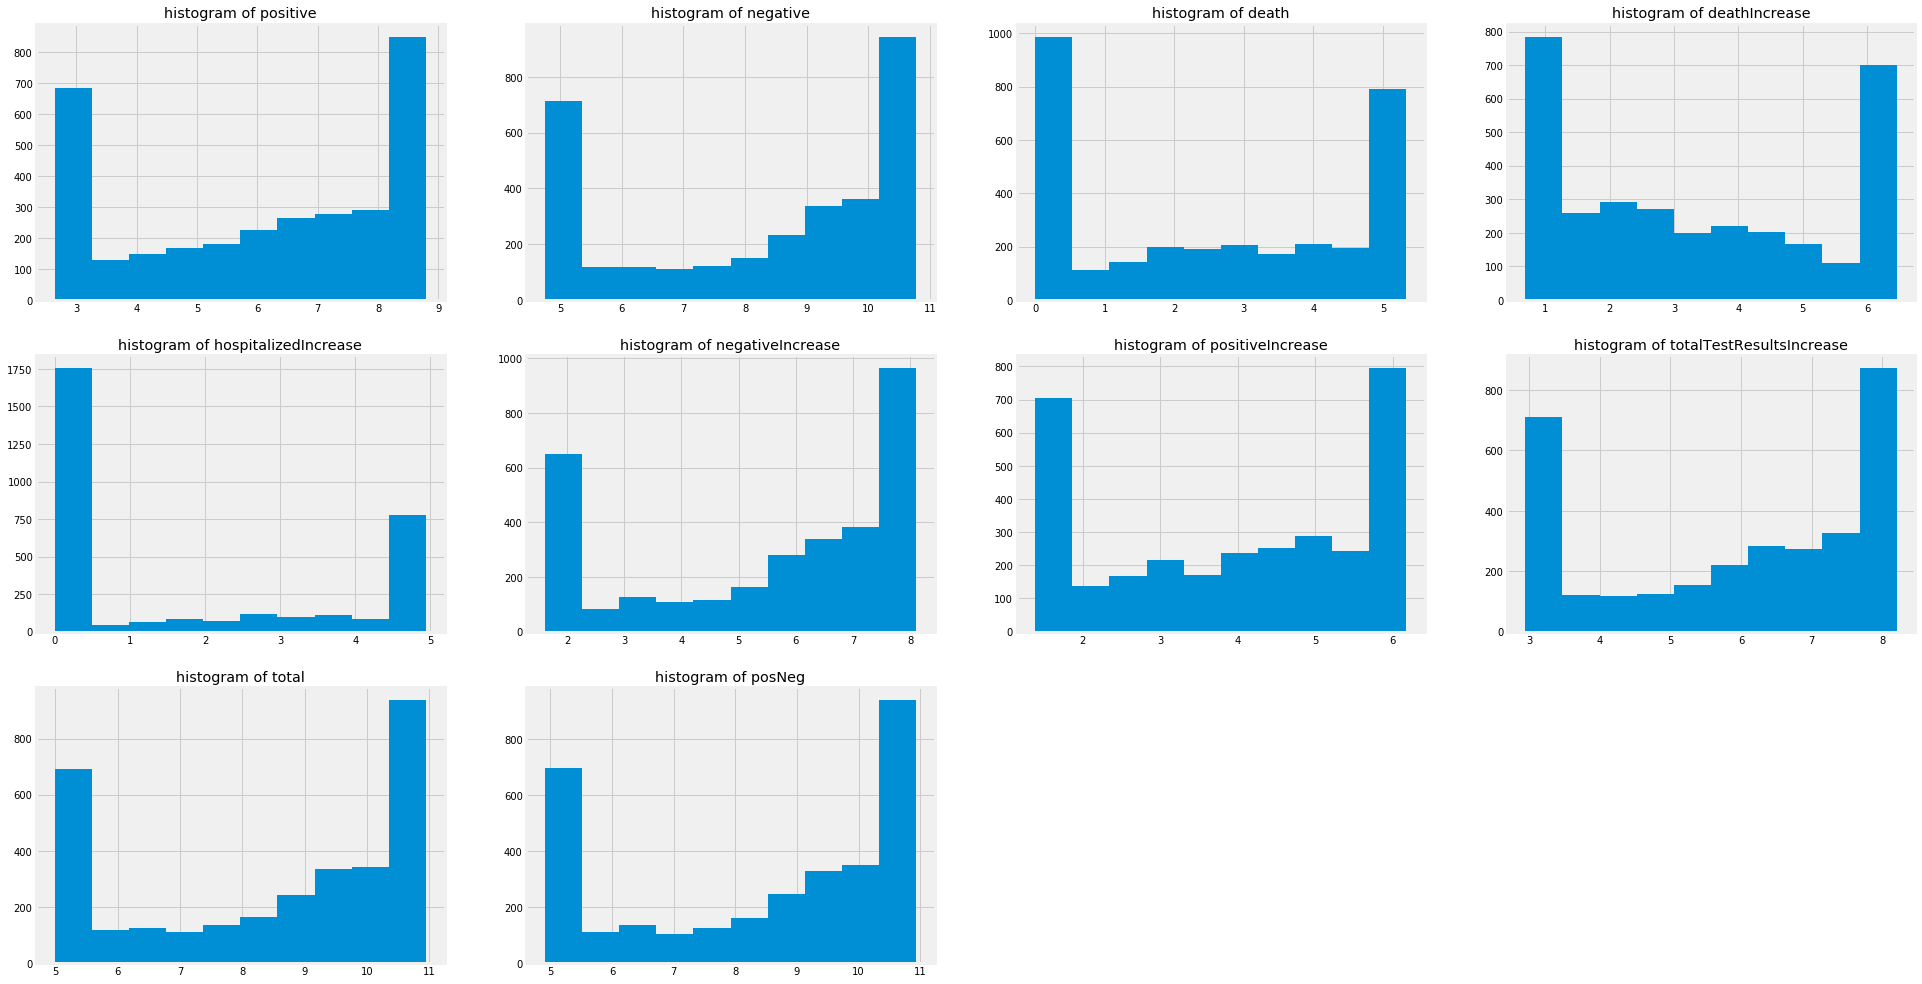

In [23]:
List = ['positive', 'negative', 'death','deathIncrease', 'hospitalizedIncrease','negativeIncrease', 'positiveIncrease', 'totalTestResultsIncrease','total','posNeg']
plt.figure(figsize=(30,60))
for i, col in enumerate (List):
    plt.subplot(len(List),4,i+1)
    plt.hist(df[col])
    plt.title("histogram of {}".format(col))
    
plt.show()

The distribution looks better than how it was before normalizing it.

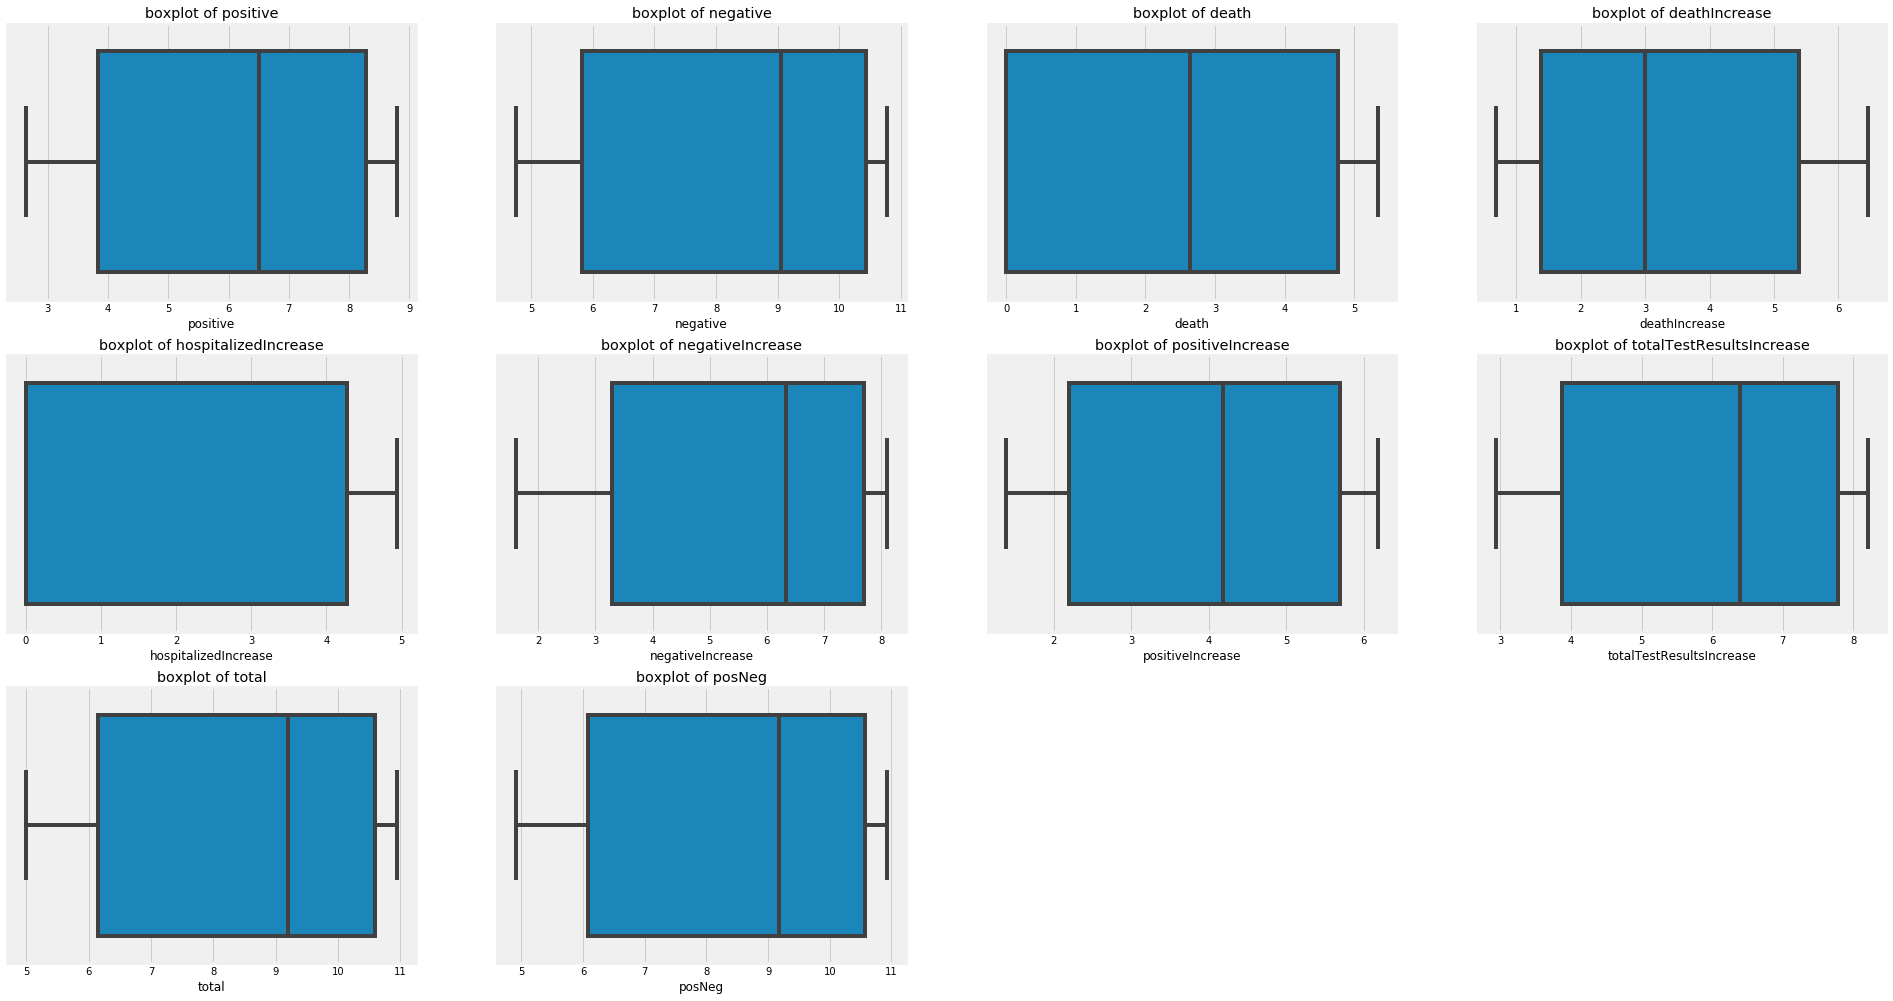

In [24]:
List = ['positive', 'negative', 'death','deathIncrease', 'hospitalizedIncrease','negativeIncrease', 'positiveIncrease', 'totalTestResultsIncrease','total','posNeg']
plt.figure(figsize=(30,60))
for i, col in enumerate (List):
    plt.subplot(len(List),4,i+1)
    sns.boxplot(df[col])
    plt.title("boxplot of {}".format(col))
    
plt.show()

No outliers, perfect for the regression model.

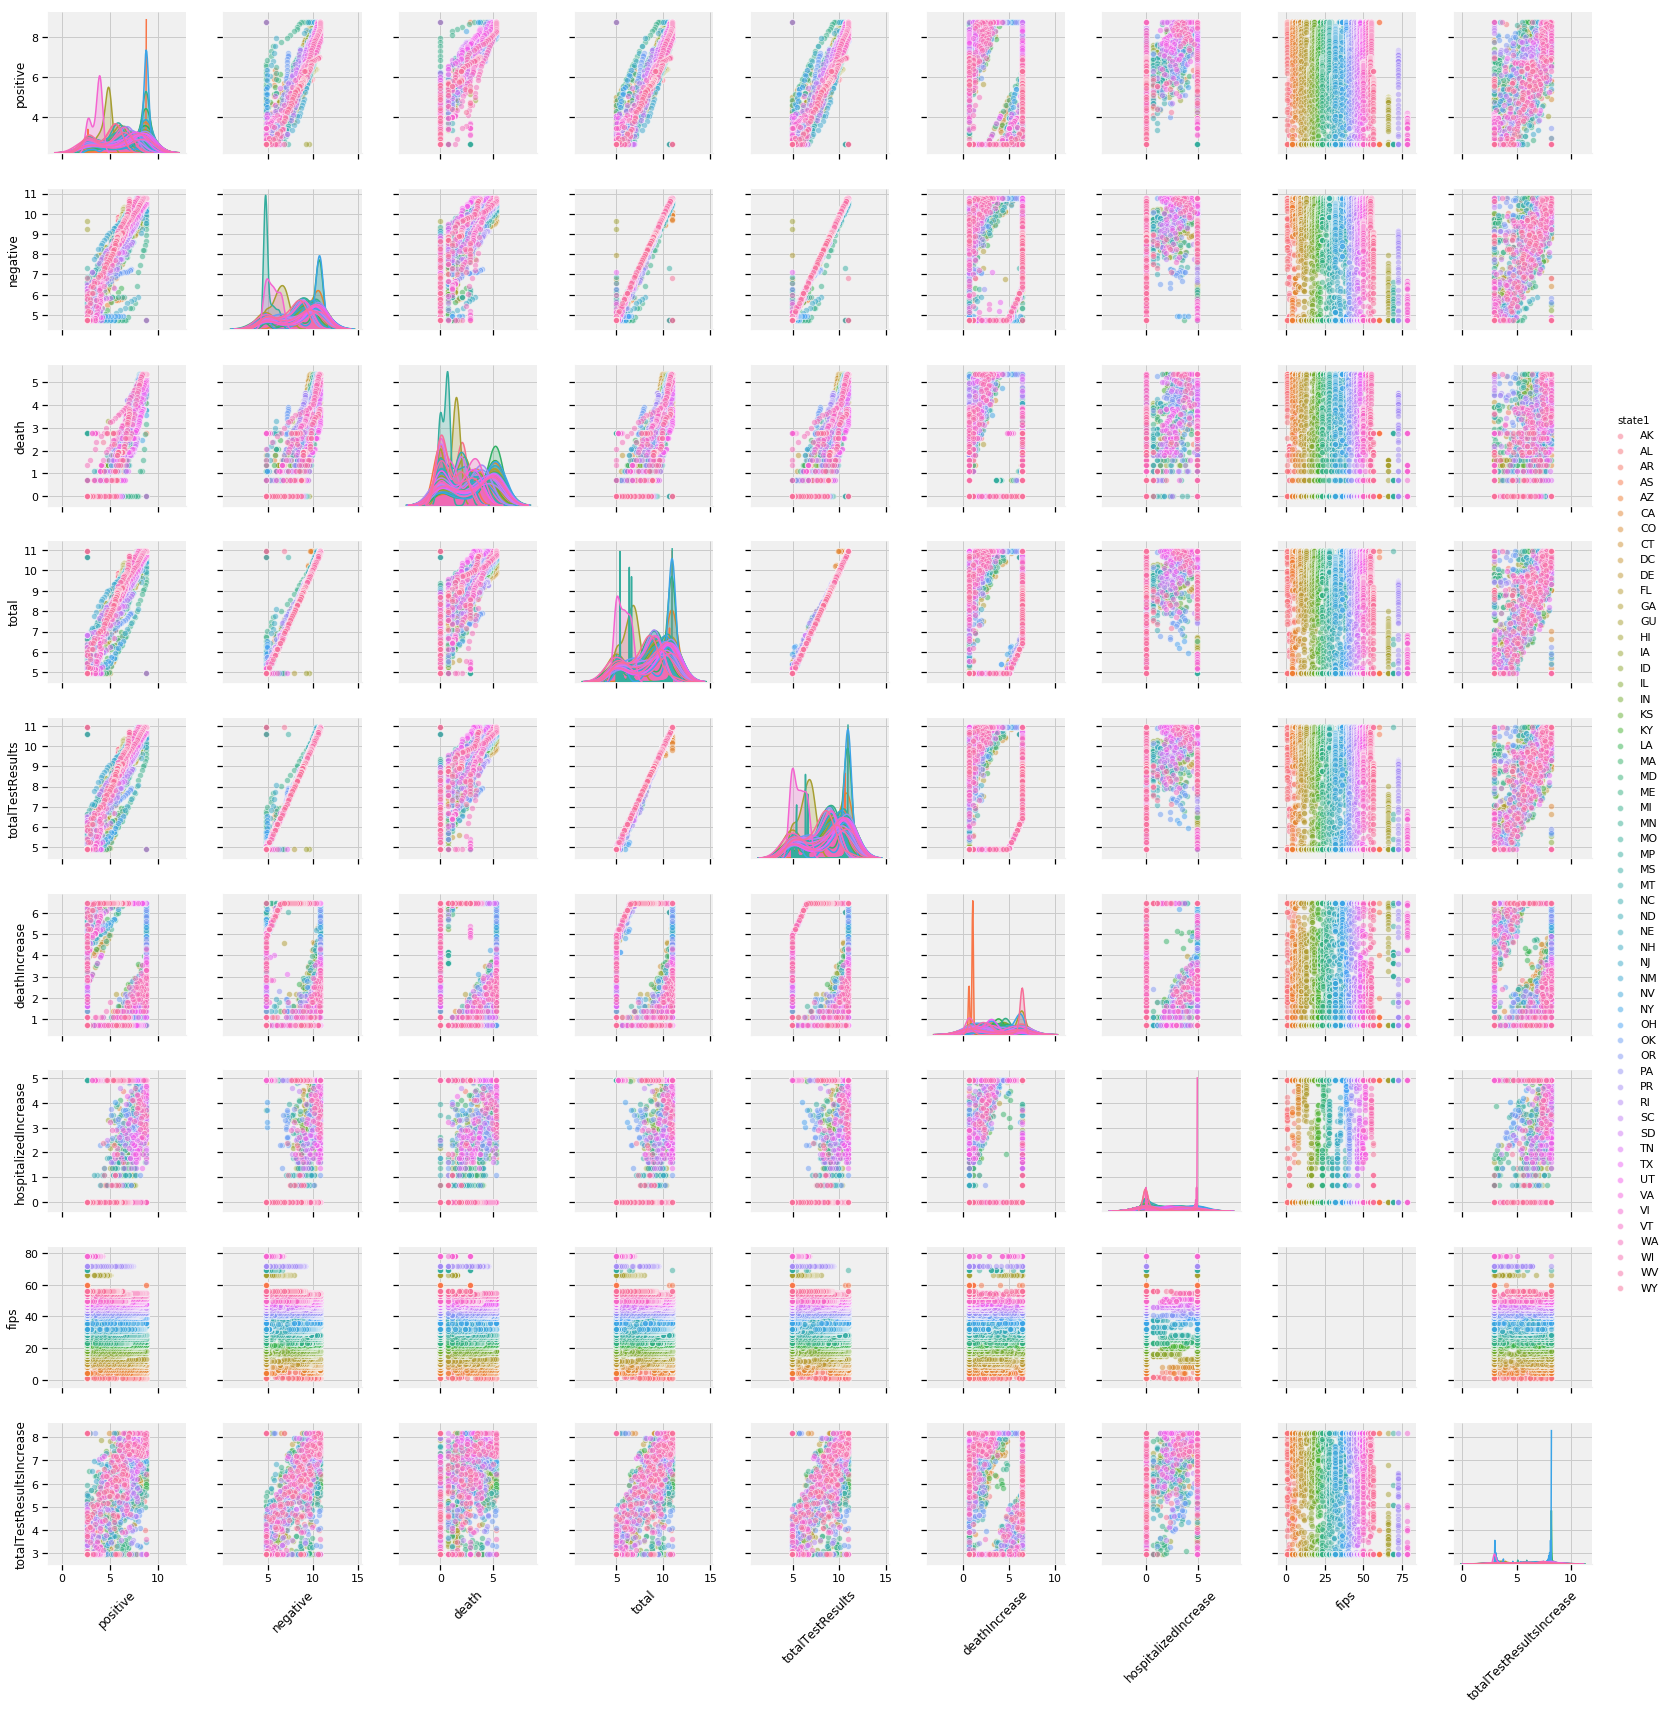

In [25]:
df['state1'] = LE.inverse_transform(df['state'])
with sns.plotting_context("notebook", font_scale=1):
    g = sns.pairplot(df, 
                 plot_kws={'alpha':0.5, },
                 vars=['positive', 
                       'negative', 'death','total', 'totalTestResults', 
                       'deathIncrease', 'hospitalizedIncrease', 'fips', 'totalTestResultsIncrease'],
                 hue="state1", 
                markers= 'o',
                )
   
    for ax in g.axes.flat: 
        ax.set_xlabel(ax.get_xlabel(), rotation=45)
plt.show()

In [26]:
#Correlation Heatmap
corrs = df.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
figure

As expected, positive cases has high correlation with test results increase.

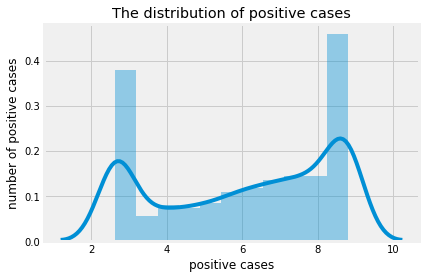

In [27]:
ax = sns.distplot(df.positive)
ax.set_title("The distribution of positive cases")
ax.set_xlabel("positive cases")
ax.set_ylabel("number of positive cases")
plt.show()

Linear Regression Model

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3209 entries, 0 to 3208
Data columns (total 14 columns):
state                       3209 non-null int64
positive                    3209 non-null float64
negative                    3209 non-null float64
death                       3209 non-null float64
total                       3209 non-null float64
totalTestResults            3209 non-null float64
posNeg                      3209 non-null float64
fips                        3209 non-null int64
deathIncrease               3209 non-null float64
hospitalizedIncrease        3209 non-null float64
negativeIncrease            3209 non-null float64
positiveIncrease            3209 non-null float64
totalTestResultsIncrease    3209 non-null float64
state1                      3209 non-null object
dtypes: float64(11), int64(2), object(1)
memory usage: 351.1+ KB


In [29]:
X = df.drop(columns=['positive','state1'], axis=1)
Y = df.positive

In [30]:
# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               positive   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     4070.
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        11:40:11   Log-Likelihood:                -2030.3
No. Observations:                2567   AIC:                             4085.
Df Residuals:                    2555   BIC:                             4155.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0307      0.078      0.395      0.693      -0.122       0.183
state                        0.0035      0.001      2.925      0.003       0.001       0.006
negative                     0.3148      0.027     11.732      0.000       0.262       0.367
death                        0.3375      0.013     26.047      0.000       0.312       0.363
total                        0.0095      0.124      0.076      0.939      -0.233       0.252
totalTestResults             0.1314      0.062      2.109      0.035       0.009       0.254
posNeg                       0.1314      0.062      2.109      0.035       0.009       0.254
fips                        -0.0058      0.001     -5.486      0.000      -0.008      -0.004
deathIncrease               -0.0011      0.005     -0.212      0.832      -0.011       0.009
hospitalizedIncrease         0.0043      0.006      0.732      0.464      -0.007       0.016
negativeIncrease            -0.0277      0.012     -2.327      0.020      -0.051      -0.004
positiveIncrease             0.3089      0.014     22.600      0.000       0.282       0.336
totalTestResultsIncrease    -0.1201      0.021     -5.674      0.000      -0.162      -0.079
==============================================================================
Omnibus:                     1983.945   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           137811.413
Skew:                           3.077   Prob(JB):                         0.00
Kurtosis:                      38.364   Cond. No.                     1.55e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.83e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

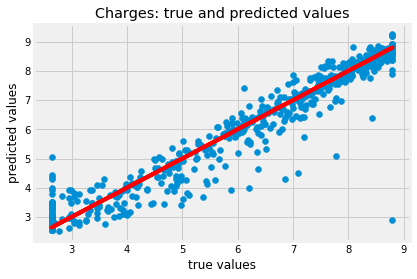

Mean absolute error of the prediction is: 0.3240981162257709
Mean squared error of the prediction is: 0.2965534280272558
Root mean squared error of the prediction is: 0.5445671933079111
Mean absolute percentage error of the prediction is: 6.90467079324992


In [31]:
# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

**Linear Regression**

In [32]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.9460148246582009
-----Test set statistics-----
R-squared of the model in test set is: 0.9430227393413498
Mean absolute error of the prediction is: 0.32409811622577384
Mean squared error of the prediction is: 0.29655342802725393
Root mean squared error of the prediction is: 0.5445671933079094
Mean absolute percentage error of the prediction is: 6.9046707932500855


In [33]:
plt.plot(X_test['negative'],'>',X_test['death'],'+', X_test['totalTestResultsIncrease'], '<',
         lrm.predict(X_test),'.')
plt.show()

**Lasso Regression** 

Similar to Ridge Regression, Lasso (Least Absolute Shrinkage and Selection Operator) also penalizes the absolute size of the regression coefficients. In addition, it is capable of reducing the variability and improving the accuracy of linear regression models

In [34]:
## 10** (p-values from -10 to 40)
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.001
R-squared of the model in training set is: 0.9460073174912255
-----Test set statistics-----
R-squared of the model in test set is: 0.942950097107336
Mean absolute error of the prediction is: 0.3238279116563739
Mean squared error of the prediction is: 0.29693151400870205
Root mean squared error of the prediction is: 0.5449142262858458
Mean absolute percentage error of the prediction is: 6.8984867180011165


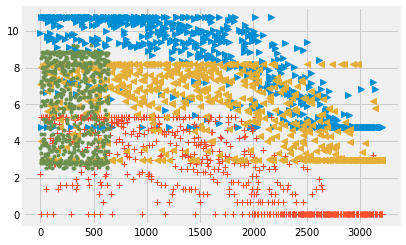

In [35]:
plt.plot(X_test['negative'],'>',X_test['death'],'+', X_test['totalTestResultsIncrease'], '<',
         lasso_cv.predict(X_test),'.')
plt.show()

**Ridge Regression**

In multicollinearity, even though the least squares estimates (OLS) are unbiased, their variances are large which deviates the observed value far from the true value. By adding a degree of bias to the regression estimates, ridge regression reduces the standard errors.

In [36]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 10.0
R-squared of the model in training set is: 0.9460113203018429
-----Test set statistics-----
R-squared of the model in test set is: 0.9429905996599846
Mean absolute error of the prediction is: 0.32386457825285186
Mean squared error of the prediction is: 0.29672070761518804
Root mean squared error of the prediction is: 0.544720761138391
Mean absolute percentage error of the prediction is: 6.903031103816128


In [37]:
plt.plot(X_test['negative'],'>',X_test['death'],'+',X_test['totalTestResultsIncrease'], '<',
         ridge_cv.predict(X_test),'.')
plt.show()

**ElasticNet Regression**

ElasticNet is hybrid of Lasso and Ridge Regression techniques. It is trained with L1 and L2 prior as regularizer. Elastic-net is useful when there are multiple features which are correlated. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.

A practical advantage of trading-off between Lasso and Ridge is that, it allows Elastic-Net to inherit some of Ridge’s stability under rotation.

In [38]:
## 10** (p-values from -10 to 40)
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.001
R-squared of the model in training set is: 0.9460090088240453
-----Test set statistics-----
R-squared of the model in test set is: 0.942953050682823
Mean absolute error of the prediction is: 0.3238288069721661
Mean squared error of the prediction is: 0.2969161413332615
Root mean squared error of the prediction is: 0.5449001205113295
Mean absolute percentage error of the prediction is: 6.897901530691905


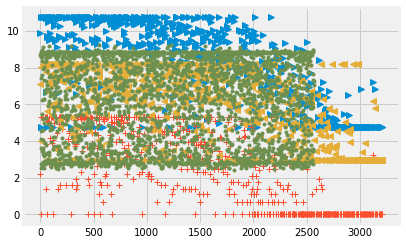

In [39]:
plt.plot(X_test['negative'],'>',X_test['death'],'+',X_test['totalTestResultsIncrease'], '<',
         elasticnet_cv.predict(X_train),'.')
plt.show()

In [40]:
#predictions!
df_pred = pd.DataFrame(y_preds_test, columns=['Predictions of Positive Cases'])
df_pred.head()

Predictions of Positive Cases
0                       3.607435
1                       7.263564
2                       2.813458
3                       5.933575
4                       3.330606

**Evaluation**

The model was analysed with different regression models. We were able to find the highest R values in Linear regression and Ridge regression. The values did not vary much from the other models. We will now try to include other factors that could possibly affect our model.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=40)
clf = LinearRegression()
cv_scores = cross_val_score(clf, X_train, y_train, cv = 5)

print('Accuracy scores for the 5 folds: ', cv_scores)
print('Mean cross validatiion score: {:.3f}'.format(np.mean(cv_scores)))

Accuracy scores for the 5 folds:  [0.95681933 0.91520522 0.96117649 0.93703005 0.95973818]
Mean cross validatiion score: 0.946


### Summary for part 1 of the project:
* The data was visualized for the top 10 countries that are affected, putting them in priority.
* Washington State's recovery level is comparatively higher to other states.
* New York city is the highest affected, however, the curve is starting to flatten from the peak.
* I could have hypertuned it by adding features, but it would not make sense for a covid-19 dataset.
* All the models are predicting a good score of about 95%.
* The accuracies were cross validated using k-fold method.
* MAE, MSE, RMSE and MAPE are considerably low which is good for the model.

### Final Capstone Project - Part 2

* Predicting COVID-19 Using Deep Learning's CNN

### Introduction:

As mentioned above, I will use an open reasearch database from github that provides chest x-ray images of covid-19 patients and combine another dataset that contains chest x-rays of normal patients.


### Summary 

In [42]:
import pandas as pd
import numpy as np# forlinear algebra
from numpy import array 
import matplotlib.pyplot as plt #for plotting things
import seaborn as sns
import os
from PIL import Image
from pathlib import Path
from skimage.io import imread
import cv2
from sklearn.metrics import confusion_matrix
print(os.listdir("../chest_xray/chest_xray2/train/"))

# Keras Libraries
import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import Dense, Dropout, Flatten, Input, ZeroPadding2D
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import regularizers
from keras import optimizers
from keras.models import load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

['covid19', '.DS_Store', 'normal']


Using TensorFlow backend.


In [43]:
data_dir = Path('../chest_xray/chest_xray2')
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

In [44]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'normal/'
covid19_cases_dir = train_dir / 'covid19/'

types = ('*.jpg', '*.jpeg') # the tuple of file types
normal_cases = []
covid19_cases =[]
for files in types:
    normal_cases.extend(normal_cases_dir.glob(files))
    covid19_cases.extend(covid19_cases_dir.glob(files))

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in covid19_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

image  label
0  ../chest_xray/chest_xray2/train/normal/IM-0168...      0
1  ../chest_xray/chest_xray2/train/covid19/augmen...      1
2  ../chest_xray/chest_xray2/train/normal/NORMAL2...      0
3  ../chest_xray/chest_xray2/train/normal/NORMAL2...      0
4  ../chest_xray/chest_xray2/train/covid19/augmen...      1

1    1748
0    1113
Name: label, dtype: int64


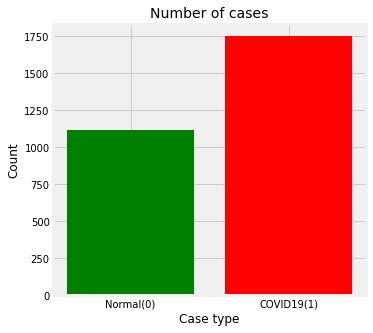

In [45]:
%matplotlib inline
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(5,5))
plt.bar(cases_count.index, cases_count.values, color='rg')
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'COVID19(1)'])
plt.show()

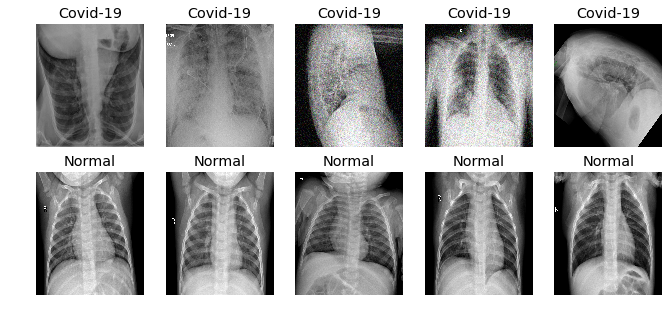

In [46]:
# Get few samples for both the classes
covid19_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = covid19_samples + normal_samples
del covid19_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(10,5))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Covid-19")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [47]:
#Validation dats
# Get the path to the normal and covi-19 sub-directories
normal_cases_dir = val_dir / 'normal/'
covid19_cases_dir = val_dir / 'covid19/'

types = ('*.jpg', '*.jpeg') # the tuple of file types
normal_cases = []
covid19_cases =[]
for files in types:
    normal_cases.extend(normal_cases_dir.glob(files))
    covid19_cases.extend(covid19_cases_dir.glob(files))

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []

# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 64x64 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1: #for gray scale hxwxrgb, we are converting it to a RGB version
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in covid19_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (304, 64, 64, 3)
Total number of labels: (304, 2)


In [48]:
import imgaug.augmenters as iaa
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [49]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 64, 64, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (64,64))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

In [50]:
visible = Input(shape=(64,64,3))
conv1 = Conv2D(16, kernel_size=(3,3), activation='relu', strides=(1, 1))(visible)
conv2 = Conv2D(16, kernel_size=(3,3), activation='relu', strides=(1, 1))(conv1)
bat1 = BatchNormalization()(conv2)
zero1 = ZeroPadding2D(padding=(1, 1))(bat1)

conv3 = Conv2D(32, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.05))(zero1)
conv4 = Conv2D(32, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.05))(conv3)
bat2 = BatchNormalization()(conv4)

conv5 = Conv2D(64, kernel_size=(3,3), activation='relu',strides=(1, 1), padding='valid')(bat2)
conv6 = Conv2D(64, kernel_size=(3,3), activation='relu',strides=(1, 1), padding='valid')(conv5)
bat3 = BatchNormalization()(conv6)
pool1 = MaxPooling2D(pool_size=(2, 2))(bat3)
zero2 = ZeroPadding2D(padding=(1, 1))(pool1)

conv7 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.01))(zero2)
conv8 = Conv2D(128, kernel_size=(2,2), activation='relu', strides=(1, 1), padding='valid')(conv7)
bat4 = BatchNormalization()(conv8)

conv9 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02))(bat4)
conv10 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02))(conv9)
bat5 = BatchNormalization()(conv10)

conv11 = Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1, 1))(bat5)
conv12 = Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1, 1))(conv11)
bat6 = BatchNormalization()(conv12)
pool2 = MaxPooling2D(pool_size=(2, 2))(bat6)

conv13 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02))(pool2)
conv14 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02))(conv13)
bat7 = BatchNormalization()(conv14)

conv15 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.05))(bat7)
conv16 = Conv2D(128, kernel_size=(2,2), activation='relu', strides=(1, 1), padding='valid')(conv15)
bat8 = BatchNormalization()(conv16)

flat = Flatten()(bat8)
hidden1 = Dense(32, activation='relu')(flat)
drop1 = Dropout(0.5)(hidden1)

hidden2 = Dense(32, activation='relu')(hidden1)
drop2 = Dropout(0.2)(hidden2)

output = Dense(2, activation='softmax')(drop2)
model = Model(inputs=visible, outputs=output)

Instructions for updating:
Colocations handled automatically by placer.


In [51]:
model.compile(optimizer= 'adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
Callbacks=[EarlyStopping(patience=3, restore_best_weights=True), 
           ReduceLROnPlateau(patience=2)]    

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 16)        64        
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 58, 58, 32)        9248

In [52]:
import h5py
# Open the VGG16 weight file
f = h5py.File('../chest_xray/chest_xray2/vgg/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary() 

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 16)        64        
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 58, 58, 32)        9248

In [53]:
batch_size = 32
nb_epochs = 10

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 89 and 304


In [54]:
# # Fit the model
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                               validation_data=(valid_data, valid_labels),callbacks= Callbacks, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
89/89 [==============================] - 126s 1s/step - loss: 11.9027 - accuracy: 0.7049 - val_loss: 9.7506 - val_accuracy: 0.5428
Epoch 2/10
89/89 [==============================] - 125s 1s/step - loss: 7.7827 - accuracy: 0.7749 - val_loss: 6.4974 - val_accuracy: 0.5428
Epoch 3/10
89/89 [==============================] - 125s 1s/step - loss: 5.1895 - accuracy: 0.8100 - val_loss: 4.5333 - val_accuracy: 0.5428
Epoch 4/10
89/89 [==============================] - 123s 1s/step - loss: 3.6308 - accuracy: 0.8027 - val_loss: 3.2738 - val_accuracy: 0.5428
Epoch 5/10
89/89 [==============================] - 123s 1s/step - loss: 2.5669 - accuracy: 0.8237 - val_loss: 2.5480 - val_accuracy: 0.5428
Epoch 6/10
89/89 [==============================] - 126s 1s/step - loss: 1.8575 - accuracy: 0.8357 - val_loss: 2.0155 - val_accuracy: 0.5428
Epoch 7/10
89/89 [==============================] - 129s 1s/step - loss: 1.3946 - accuracy: 0.8462 - val_

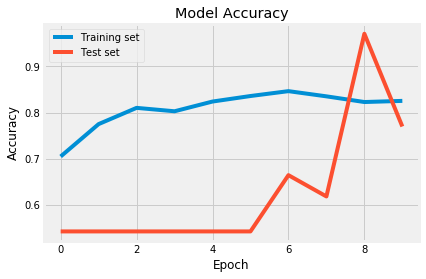

In [55]:
# Accuracy
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

Run this cell for augmenting

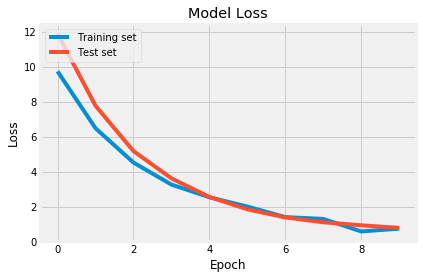

In [56]:
# Loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

In [57]:
# import numpy as np
# import cv2
# from skimage import io 
# from skimage.transform import rotate, AffineTransform, warp
# import random
# from skimage import img_as_ubyte
# import os
# from skimage.util import random_noise
# #Lets define functions for each operation
# def anticlockwise_rotation(image):
#     angle= random.randint(0,180)
#     return rotate(image, angle)

# def clockwise_rotation(image):
#     angle= random.randint(0,180)
#     return rotate(image, -angle)

# def h_flip(image):
#     return  np.fliplr(image)

# def v_flip(image):
#     return np.flipud(image)

# def add_noise(image):
#     return random_noise(image)

In [58]:
# transformations = {'rotate anticlockwise': anticlockwise_rotation,
#                       'rotate clockwise': clockwise_rotation,
#                       'horizontal flip': h_flip, 
#                       'vertical flip': v_flip,
#                    'adding noise': add_noise,
#                  }                #use dictionary to store names of functions 

# images_path='../chest_xray/chest_xray2/test/covid19' #path to original images
# augmented_path="../chest_xray/chest_xray2/test/aug_covid19" # path to store aumented images
# images=[] # to store paths of images from folder

# for im in os.listdir(images_path):  # read image name from folder and append its path into "images" array     
#     images.append(os.path.join(images_path,im))

# images_to_generate=400  #you can change this value according to your requirement
# i=1                        # variable to iterate till images_to_generate

# while i<=images_to_generate:    
#     image=random.choice(images)
#     original_image = io.imread(image,plugin='matplotlib')
#     transformed_image=None
# #     print(i)
#     n = 0       #variable to iterate till number of transformation to apply
#     transformation_count = random.randint(1, len(transformations)) #choose random number of transformation to apply on the image
    
#     while n <= transformation_count:
#         key = random.choice(list(transformations)) #randomly choosing method to call
#         transformed_image = transformations[key](original_image)
#         n = n + 1
        
#     new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
#     transformed_image = img_as_ubyte(transformed_image)  #Convert an image to unsigned byte format, with values in [0, 255].
#     transformed_image=cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB) #convert image to RGB before saving it
#     cv2.imwrite(new_image_path, transformed_image) # save transformed image to path
#     i =i+1

In [59]:
#Test data
# Get the path to the normal and covi-19 sub-directories
normal_cases_dir = test_dir / 'normal/'
covid19_cases_dir = test_dir / 'covid19/'

types = ('*.jpg', '*.jpeg') # the tuple of file types
normal_cases = []
covid19_cases =[]
for files in types:
    normal_cases.extend(normal_cases_dir.glob(files))
    covid19_cases.extend(covid19_cases_dir.glob(files))

test_data1 = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data1.append(img)
    test_labels.append(label)
                      
for img in covid19_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data1.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data1)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (261, 64, 64, 3)
Total number of labels: (261, 2)


In [60]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=32)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

261/261 [==============================] - 3s 13ms/step
Loss on test set:  0.9100638776446668
Accuracy on test set:  0.6206896305084229


In [61]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(261,)
(261,)


In [62]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 1.00
Precision of the model is 0.51


<Figure size 432x288 with 0 Axes>

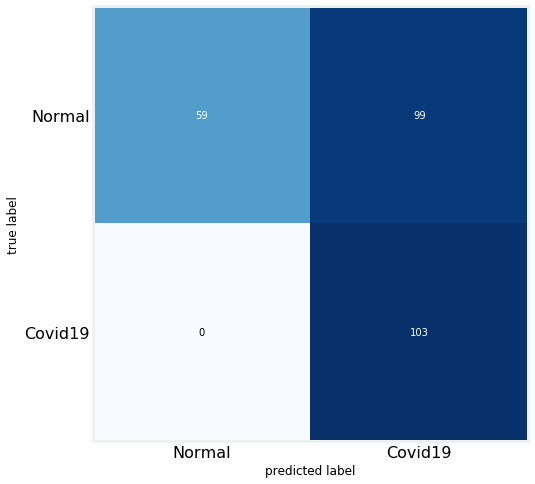

In [63]:
from mlxtend.plotting import plot_confusion_matrix
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Covid19'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Covid19'], fontsize=16)
plt.show()

MARK THE CORRECT PREDS WITH GREEN AND WRONG PREDS WITH RED- REFER COURSERA PROJECT!

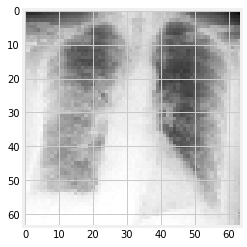

(1, 64, 64, 3)


In [64]:
from keras.preprocessing import image
img_path = '../chest_xray/chest_xray2/test/covid19/SARS-10.1148rg.242035193-g04mr34g09a-Fig9a-day17.jpeg'
img = image.load_img(img_path, target_size=(64, 64))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)

In [65]:
# Original labels
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict(images, batch_size=10)
classes = np.argmax(classes, axis=-1)
print("Predicted class is:",classes)

Predicted class is: [1]


The model has predicted that the above xray image contains covid-19, which is true. 